curl -L -o data/worldpop/raw/2019/ind_ppp_2019_1km_Aggregated.tif \
  "https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2019/IND/ind_ppp_2019_1km_Aggregated.tif"

curl -L -o data/worldpop/raw/2019/bgd_ppp_2019_1km_Aggregated.tif \
  "https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2019/BGD/bgd_ppp_2019_1km_Aggregated.tif"

**Imports + paths + bbox**

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile

from shapely.geometry import box, mapping
from pyproj import Transformer

# AOI bbox in EPSG:4326
#bbox = {"lon_min": 88.08, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.67}
bbox = {"lon_min": 88.5, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.5}


# WorldPop files (downloaded via curl)
fp_ind = Path("../data/worldpop/raw/2019/ind_ppp_2019_1km_Aggregated.tif")
fp_bgd = Path("../data/worldpop/raw/2019/bgd_ppp_2019_1km_Aggregated.tif")

# Hero png
hero_png = "../outputs/figures/ceam_sundarbans_admin_hero.png"


**Load + mosaic India & Bangladesh**

In [2]:
for p in [fp_ind, fp_bgd]:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p.resolve()}")

with rasterio.open(fp_ind) as src1, rasterio.open(fp_bgd) as src2:
    # Mosaic
    mosaic, mosaic_transform = merge([src1, src2])
    mosaic_crs = src1.crs
    mosaic_nodata = src1.nodata

print("Mosaic CRS:", mosaic_crs)
print("Mosaic shape (bands, rows, cols):", mosaic.shape)
print("Mosaic nodata:", mosaic_nodata)


Mosaic CRS: EPSG:4326
Mosaic shape (bands, rows, cols): (1, 3451, 3508)
Mosaic nodata: -99999.0


**Clip mosaic to your bbox (robust CRS handling)**

In [3]:
# AOI polygon in EPSG:4326
aoi_4326 = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])

# Reproject AOI polygon to raster CRS if needed
if str(mosaic_crs).upper() != "EPSG:4326":
    t = Transformer.from_crs("EPSG:4326", mosaic_crs, always_xy=True)
    x0, y0 = t.transform(bbox["lon_min"], bbox["lat_min"])
    x1, y1 = t.transform(bbox["lon_max"], bbox["lat_max"])
    aoi = box(min(x0, x1), min(y0, y1), max(x0, x1), max(y0, y1))
else:
    aoi = aoi_4326

aoi_geojson = [mapping(aoi)]

# Write mosaic to an in-memory GTiff so we can use rasterio.mask cleanly
meta = {
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "count": mosaic.shape[0],
    "dtype": mosaic.dtype,
    "crs": mosaic_crs,
    "transform": mosaic_transform,
    "nodata": mosaic_nodata,
}

with MemoryFile() as memfile:
    with memfile.open(**meta) as tmp:
        tmp.write(mosaic)
        pop_clip, pop_transform = mask(tmp, aoi_geojson, crop=True)

pop = pop_clip[0]
print("Clipped pop shape:", pop.shape)
print("Clipped transform:", pop_transform)


Clipped pop shape: (121, 171)
Clipped transform: | 0.01, 0.00, 88.50|
| 0.00,-0.01, 22.51|
| 0.00, 0.00, 1.00|


**Quick view of clipped WorldPop**

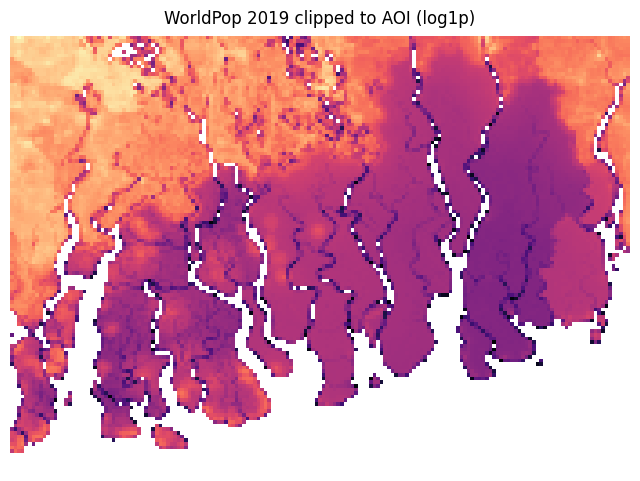

In [4]:
pop_plot = pop.astype("float32")
if mosaic_nodata is not None:
    pop_plot = np.where(pop_plot == mosaic_nodata, np.nan, pop_plot)

plt.figure(figsize=(8, 6))
plt.imshow(np.log1p(pop_plot), cmap="magma")
plt.title("WorldPop 2019 clipped to AOI (log1p)")
plt.axis("off")
plt.show()


**Quick view + scale (stats + colorbar in real units)**

People-per-pixel stats (PPP, clipped AOI):
  min=0.281  median=75.932  p90=870.560  p95=1236.089  p99=2069.614  max=3851.113


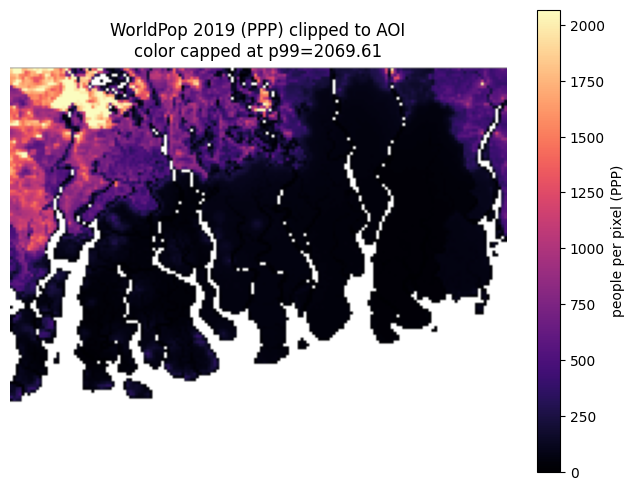

In [5]:
import numpy as np
import matplotlib.pyplot as plt

pop_plot = pop.astype("float32")
if mosaic_nodata is not None:
    pop_plot = np.where(pop_plot == mosaic_nodata, np.nan, pop_plot)

valid = pop_plot[np.isfinite(pop_plot)]
p50, p90, p95, p99 = np.percentile(valid, [50, 90, 95, 99])
vmax = p99  # cap for readability

print(f"People-per-pixel stats (PPP, clipped AOI):")
print(f"  min={np.nanmin(pop_plot):.3f}  median={p50:.3f}  p90={p90:.3f}  p95={p95:.3f}  p99={p99:.3f}  max={np.nanmax(pop_plot):.3f}")

plt.figure(figsize=(8, 6))
im = plt.imshow(pop_plot, cmap="magma", vmin=0, vmax=vmax)
plt.title(f"WorldPop 2019 (PPP) clipped to AOI\ncolor capped at p99={vmax:.2f}")
plt.axis("off")
cb = plt.colorbar(im)
cb.set_label("people per pixel (PPP)")
plt.show()


**Reproject to EPSG:3857 + overlay on hero PNG**

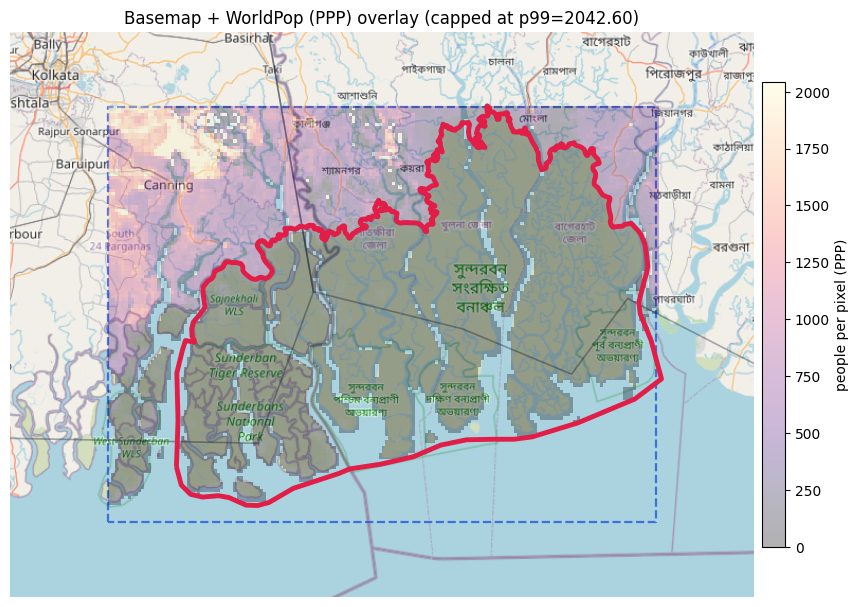

In [6]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from pyproj import Transformer
from rasterio.warp import calculate_default_transform, reproject, Resampling

# ---- 1) Reproject pop -> 3857 (same logic) ----
dst_crs = "EPSG:3857"

h, w = pop.shape
left, top = pop_transform * (0, 0)
right, bottom = pop_transform * (w, h)

dst_transform, dst_width, dst_height = calculate_default_transform(
    mosaic_crs, dst_crs, w, h, left=left, bottom=bottom, right=right, top=top
)

pop_3857 = np.full((dst_height, dst_width), np.nan, dtype=np.float32)

reproject(
    source=pop.astype(np.float32),
    destination=pop_3857,
    src_transform=pop_transform,
    src_crs=mosaic_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest,
    src_nodata=mosaic_nodata,
    dst_nodata=np.nan
)

xmin, ymax = dst_transform * (0, 0)
xmax, ymin = dst_transform * (dst_width, dst_height)
pop_extent_3857 = [xmin, xmax, ymin, ymax]

# ---- 2) Build bbox_3857 and padded extent EXACTLY like admin_boundaries ----
bbox_poly_4326 = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])
bbox_3857 = gpd.GeoDataFrame(geometry=[bbox_poly_4326], crs="EPSG:4326").to_crs(epsg=3857)

bxmin, bymin, bxmax, bymax = bbox_3857.total_bounds
pad_x = (bxmax - bxmin) * 0.18
pad_y = (bymax - bymin) * 0.18
xlim = (bxmin - pad_x, bxmax + pad_x)
ylim = (bymin - pad_y, bymax + pad_y)

# ---- 3) Load overlays (or reuse your existing region_3857/sund_3857) ----
ne_path = "../data/basemaps/natural_earth/ne_110m_admin_0_countries.shp"
sund_path = "../data/basemaps/osm/sundarbans_relation_14937802.geojson"  # adjust if needed

region_3857 = gpd.read_file(ne_path).to_crs(epsg=3857)
sund = gpd.read_file(sund_path)
sund_3857 = sund[sund.geometry.type.isin(["Polygon", "MultiPolygon"])].to_crs(epsg=3857)

# ---- 4) Plot hero + WorldPop (PPP) with scale ----
valid = pop_3857[np.isfinite(pop_3857)]
p99 = np.percentile(valid, 99)
vmax = p99

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857", attribution=False)

region_3857.boundary.plot(ax=ax, color="#111827", linewidth=1.2, alpha=0.35, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=1.6, linestyle="--", alpha=0.75, zorder=5)
sund_3857.boundary.plot(ax=ax, color="#E11D48", linewidth=3.5, zorder=10)

im = ax.imshow(pop_3857, extent=pop_extent_3857, cmap="magma", alpha=0.3, vmin=0, vmax=vmax, zorder=6)

ax.set_title(f"Basemap + WorldPop (PPP) overlay (capped at p99={vmax:.2f})")
ax.axis("off")
cb = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
cb.set_label("people per pixel (PPP)")
plt.show()


In [7]:
import geopandas as gpd

sund = gpd.read_file("../data/basemaps/osm/sundarbans_relation_14937802.geojson")

# Keep only polygons (drop lines/points)
sund_poly = sund[sund.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

sund_3857 = sund_poly.to_crs(epsg=3857)

In [8]:
import numpy as np
from rasterio.features import geometry_mask

# pop_3857: float32 array with np.nan as nodata (as in your cell)
# dst_transform: affine transform for pop_3857
# sund_3857: GeoDataFrame in EPSG:3857

# 1) Total population in the (already clipped) bbox
pop_bbox_sum = np.nansum(pop_3857)

# 2) Mask for pixels INSIDE Sundarbans polygon
sund_union = sund_3857.geometry.unary_union
inside_mask = geometry_mask(
    [sund_union],
    out_shape=pop_3857.shape,
    transform=dst_transform,
    invert=True,        # True = inside polygon
    all_touched=False
)

pop_in_sund = np.where(inside_mask, pop_3857, np.nan)
pop_sund_sum = np.nansum(pop_in_sund)

# 3) Print results
print(f"Total pop in bbox (sum PPP over raster pixels): {pop_bbox_sum:,.0f}")
print(f"Total pop inside sund_3857 polygon:             {pop_sund_sum:,.0f}")
print(f"Share inside polygon:                           {100*pop_sund_sum/pop_bbox_sum:.2f}%")


Total pop in bbox (sum PPP over raster pixels): 4,669,585
Total pop inside sund_3857 polygon:             559,277
Share inside polygon:                           11.98%


/var/folders/53/ps9kkpj52j71m9fx4fmfqxsw0000gn/T/ipykernel_43337/770498284.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sund_union = sund_3857.geometry.unary_union


In [9]:
# ---- Convert from people-per-pixel to people-per-sq-km (EPSG:3857 pixel area in m^2) ----
pixel_width_m  = dst_transform.a
pixel_height_m = abs(dst_transform.e)  # e is typically negative
pixel_area_m2  = pixel_width_m * pixel_height_m
pixel_area_km2 = pixel_area_m2 / 1e6

pop_density_km2 = pop_3857 / pixel_area_km2


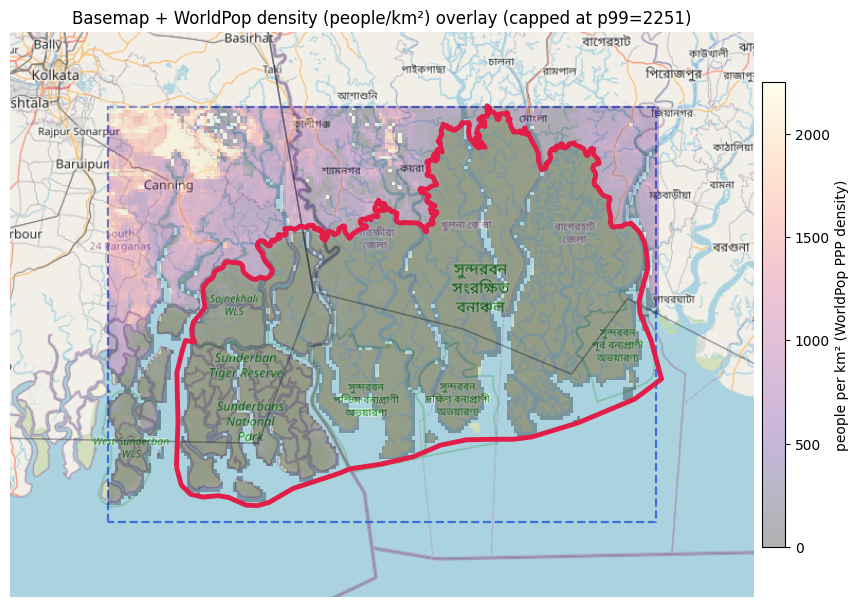

In [10]:
# ---- 4) Plot hero + WorldPop density with scale ----
valid = pop_density_km2[np.isfinite(pop_density_km2)]
p99 = np.percentile(valid, 99)
vmax = p99

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857", attribution=False)

region_3857.boundary.plot(ax=ax, color="#111827", linewidth=1.2, alpha=0.35, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=1.6, linestyle="--", alpha=0.75, zorder=5)
sund_3857.boundary.plot(ax=ax, color="#E11D48", linewidth=3.5, zorder=10)

im = ax.imshow(
    pop_density_km2,
    extent=pop_extent_3857,
    cmap="magma",
    alpha=0.3,
    vmin=0,
    vmax=vmax,
    zorder=6
)

ax.set_title(f"Basemap + WorldPop density (people/km²) overlay (capped at p99={vmax:.0f})")
ax.axis("off")
cb = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
cb.set_label("people per km² (WorldPop PPP density)")
plt.show()
